In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import OneClassSVM

!pip install pyod
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.ocsvm import OCSVM
from pyod.models.vae import VAE

!pip install umap-learn
import umap

!pip install --upgrade tensorflow
!pip install tensorflow-hub
import tensorflow as tf
tf.executing_eagerly()
import tensorflow_hub as hub

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
embed = hub.load(module_url)

Requirement already up-to-date: tensorflow in c:\users\mrric\anaconda3\lib\site-packages (2.3.0)


ImportError: cannot import name 'add_to_collection' from 'tensorflow' (C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\__init__.py)

# Load data
Split into training and test data <br>
Test data includes new labels/categories not seen in training data

## Load extracted n26 data

In [ ]:
vectors = pd.read_csv("data/extracted_n26_tsv_vecs.tsv", delimiter='\t|,', header=None, engine='python')
vectors = vectors.drop(vectors.columns[0], axis=1)
metadata = pd.read_csv("data/extracted_n26_tsv_metadata.tsv", delimiter='\t')

vec_meta = vectors.join(metadata)
train = vec_meta[vec_meta['FAQ_id'] <= 134] # only train on first 130 classes
train = train.drop(['FAQ_id', 'locale', 'market', 'question'], axis=1)

test_novel = vec_meta[vec_meta['FAQ_id'] > 134]
test_novel = test_novel.drop(['FAQ_id', 'locale', 'market', 'question'], axis=1)

test_not_novel = train.sample(n=30, random_state=56) # random sample of non-novel clusters
train = pd.concat([train,test_not_novel]).drop_duplicates(keep=False) # train data cannot contain test data

test = pd.concat([test_novel, test_not_novel]).drop_duplicates(keep=False)

## Load and embed 20newsgroups data

In [3]:
print("Loading 20newsgroups data...")
newsgroups_train = fetch_20newsgroups(subset='train', categories=['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space'])
# newsgroups_test_novel = fetch_20newsgroups(subset='test', categories=['rec.autos', 'rec.motorcycles'])
newsgroups_test = fetch_20newsgroups(subset='test', 
                                     categories=['sci.med', 'sci.space', 'rec.autos', 'talk.politics.mideast', 'soc.religion.christian'])

newsgroups_train_df = pd.DataFrame(newsgroups_train.data)
newsgroups_test_df = pd.DataFrame(newsgroups_test.data)
print(newsgroups_train_df)
print(newsgroups_test_df)

Loading 20newsgroups data...
                                                      0
0     From: al@escom.com (Al Donaldson)\nSubject: Re...
1     From: harpe@netnews.louisville.edu (Mike Harpe...
2     From: henry@zoo.toronto.edu (Henry Spencer)\nS...
3     From: geva@concave.cs.wits.ac.za (Geva Patz)\n...
4     From: rdl1@ukc.ac.uk (R.D.Lorenz)\nSubject: Co...
...                                                 ...
2368  From: tcmay@netcom.com (Timothy C. May)\nSubje...
2369  From: bebmza@sru001.chvpkh.chevron.com (Beverl...
2370  From: wallacen@CS.ColoState.EDU (nathan wallac...
2371  From: clj@ksr.com (Chris Jones)\nSubject: Re: ...
2372  From: philc@macs.ee.mcgill.ca (Phil Crawley)\n...

[2373 rows x 1 columns]
                                                      0
0     From: tedr@athena.cs.uga.edu (Ted Kalivoda)\nS...
1     From: f54oguocha@edison.usask.ca\nSubject: RE:...
2     From: eliot@lanmola.engr.washington.edu (eliot...
3     From: swkirch@sun6850.nrl.navy.mil (Steve Ki

In [4]:
print("Embedding training text...")
train = embed(newsgroups_train.data)
train_vec_df = pd.DataFrame(train)
train_vec_df.to_pickle('data/train_vec.pkl')
    
print("Embedding test text...")
test = embed(newsgroups_test.data)
test_vec_df = pd.DataFrame(test)
test_vec_df.to_pickle('data/test_vec.pkl')

Embedding training text...
Embedding test text...


In [ ]:
# Load pre-embedded data
train = pd.read_pickle('data/train_vec.pkl')
test = pd.read_pickle('data/test_vec.pkl')

# Dimensionality reduction
Results in better outlier detection <br>
UMAP works better than PCA <br>
__Important to select the "right" number of components__

In [9]:
def reduce(dataframe, reducer='umap', n_comp=50):
    if reducer == 'pca':
        reducer = PCA(n_components=n_comp)
    elif reducer == 'svd':
        reducer = TruncatedSVD(n_components=n_comp)
    else:
        reducer = umap.UMAP(n_components=n_comp)
    scaled_data = StandardScaler().fit_transform(dataframe)
    embedding = reducer.fit_transform(scaled_data)
    embedding = pd.DataFrame(embedding)
    return embedding, reducer

X_train, reducer = reduce(train, reducer='pca', n_comp=200)
X_test, reducer = reduce(test, reducer='pca', n_comp=200)

# percentage_var_explained = reducer.explained_variance_ratio_
# cum_var_explained=np.cumsum(percentage_var_explained)
# #plot PCA spectrum   
# plt.figure(1,figsize=(6,4))
# plt.clf()  
# plt.plot(cum_var_explained,linewidth=2)  
# plt.axis('tight')  
# plt.grid() 
# plt.xlabel('n_components') 
# plt.ylabel('Cumulative_Variance_explained')  
# plt.show()

# X_train = train
# X_test = test

# print(X_train)
# print(X_test)

# Novelty detection

In [106]:
def lof(train_data, test_data):
    clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination='auto')
    clf.fit(train_data)
    y_train_scores = clf.negative_outlier_factor_
    
#     y_pred_test = clf.predict(test_data)
    y_test_scores = clf.score_samples(test_data)  # outlier scores
    y_test_scores = pd.Series(y_test_scores)
    return test_data, y_train_scores, y_test_scores

X_test, y_train_scores, y_test_scores = lof(X_train, X_test)

## Fit autoencoder
__Select from 3 neural-net architectures__

In [6]:
def autoencode(train_data, test_data):
#     clf1 = AutoEncoder(hidden_neurons=[25, 2, 2, 25], epochs=50)
#     clf1 = AutoEncoder(hidden_neurons=[25, 10, 2, 10, 25])
#     clf1 = AutoEncoder(hidden_neurons=[25, 15, 10, 2, 10, 15, 25], epochs=50, contamination=0.4)
    clf1 = AutoEncoder(hidden_neurons=[300, 600, 50, 600, 300], epochs=50, contamination=0.4)

#     clf1 = CBLOF(contamination=0.5)
#     clf1 = HBOS(contamination=0.5)
#     clf1 = KNN(contamination=0.5)
#     clf1 = OCSVM(contamination=0.4)
    clf1.fit(train_data)

    # Get the outlier scores for the train data
    y_train_scores = clf1.decision_scores_

    # Predict the anomaly scores
    y_test_scores = clf1.decision_function(test_data)  # outlier scores
    y_test_scores = pd.Series(y_test_scores)
    return test_data, y_train_scores, y_test_scores

X_test, y_train_scores, y_test_scores = autoencode(X_train, X_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                5025      
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 15)               

In [2]:
# Plot it!
plt.hist([y_train_scores, y_test_scores], bins=50, label=['train','test'])
plt.legend(prop={'size': 10})
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

NameError: name 'y_train_scores' is not defined

## View data
__Choose decision boundary based off of x-coord on plot__
__Returns dataframe sorted by novelty score__

In [97]:
def get_novel(X_test, y_test_scores, decision):
    df_test = X_test.copy()
    df_test['score'] = y_test_scores

    # Lower score is non-novel, higher score is novel
    # --> 0: non-novel, 1: novel
    df_test['cluster'] = np.where(df_test['score'] > decision, 0, 1)
    df_test['cluster'].value_counts()
    df_test.groupby('cluster').mean()

    output = pd.merge(df_test, newsgroups_test_df, left_index=True, right_index=True)
    output['score'] = y_test_scores
    return output

decision = 0.1
output_df = get_novel(X_test, y_test_scores, decision)
print(output_df[['cluster', 'score', '0_y']].sort_values(by=['score']))
print(output_df["0_y"][1539])

      cluster         score                                                0_y
0           1  0.000000e+00  From: tedr@athena.cs.uga.edu (Ted Kalivoda)\nS...
1313        1  0.000000e+00  From: kjenks@gothamcity.jsc.nasa.gov\nSubject:...
1312        1  0.000000e+00  From: smayo@world.std.com (Scott A Mayo)\nSubj...
1311        1  0.000000e+00  From: richmond@spiff.Princeton.EDU (Stupendous...
1310        1  0.000000e+00  From: Mike.Hahn@p57.f714.n7102.z5.fidonet.org ...
...       ...           ...                                                ...
645         1  0.000000e+00  From: hyder@cs.utexas.edu (Syed Irfan Hyder)\n...
656         1  0.000000e+00  From: isaackuo@skippy.berkeley.edu (Isaac Kuo)...
1959        1  0.000000e+00  From: eshneken@ux4.cso.uiuc.edu (Edward A Shne...
570         1  1.110223e-16  From: ddavis@cass.ma02.bull.com (Dave Davis)\n...
693         1  5.551115e-16  From: shaig@think.com (Shai Guday)\nSubject: R...

[1960 rows x 3 columns]
From: creps@lateran.ucs.ind

## Cluster novel data
__Choose k using elbow method__

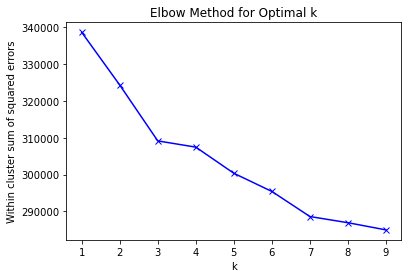

In [72]:
def cluster_novel(novel_df, k):
#     novel_df = novel_df.drop(columns=['cluster', 'score'])
    model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=50, verbose=0)
    model.fit(novel_df)
    return model.inertia_

novel_df = output_df[output_df['cluster'] == 1].drop(columns=['cluster', 'score', '0_y'])
inertias = []
for k in range(1, 10):
    inertia = cluster_novel(novel_df, k)
    inertias.append(inertia)

# Using elbow method to select optimal k
# Optimal k is found at the place with highest curvature
plt.plot(range(1,10), inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Within cluster sum of squared errors')
plt.title('Elbow Method for Optimal k')
plt.show()

## Get cluster labels for novel data
__Assign topics to new clusters__

In [73]:
k = 3
# novel_df = novel_df.drop(columns=['cluster', 'score'])
model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=50, verbose=0)
labels = model.fit_predict(novel_df)
print(labels)

[1 2 0 2 1 1 1 1 2 0 0 0 2 1 1 1 1 2 0 1 1 1 1 1 2 0 2 2 2 2 2 1 2 1 1 0 0
 2 2 0 1 1 2 0 0 2 0 0 2 1 2 2 0 2 1 1 0 0 1 0 0 2 1 1 0 1 1 1 1 1 1 1 0 1
 1 0 1 1 1 1 2 0 1 1 0 0 0 2 0 0 0 2 1 0 2 1 1 0 0 1 0 2 0 0 1 1 2 0 1 0 2
 1 1 0 0 0 0 0 2 1 1 0 1 1 1 1 0 1 2 2 1 0 0 2 2 1 1 1 1 0 0 1 2 1 0 0 0 1
 0 0 1 1 1 2 1 1 0 1 2 0 2 2 0 0 2 1 2 0 1 0 1 2 1 1 0 0 0 0 1 1 0 1 1 0 1
 1 2 1 1 0 2 2 0 2 0 0 1 1 1 1 1 1 0 0 1 0 0 2 2 0 1 0 0 2 1 0 2 2 1 0 1 1
 2 0 0 1 2 0 2 1 2 0 1 0 1 1 1 1 0 0 2 1 1 0 1 0 0 2 2 0 1 1 0 1 1 0 2 0 1
 1 2 2 2 1 2 0 2 1 1 1 2 1 1 0 1 2 1 2 1 2 1 1 1 0 0 2 1 2 1 0 1 0 1 0 1 2
 2 1 0 1 1 1 1 0 2 1 0 0 2 2 1 0 1 1 0 1 0 0 2 1 0 0 1 1 2 0 2 2 2 2 1 1 1
 2 2 0 0 2 1 0 2 1 0 1 0 0 0 1 2 2 1 1 1 0 1 1 1 1 1 0 2 2 2 0 0 1 1 0 2 1
 0 2 1 1 0 0 0 0 2 0 2 1 0 2 1 0 1 2 0 1 1 2 1 0 1 0 1 0 0 1 0 0 1 2 0 1 2
 1 2 0 2 1 2 2 1 2 1 0 1 1 2 2 1 1 2 2 2 1 1 0 2 1 1 2 0 1 2 0 1 2 2 0 2 0
 1 1 0 0 0 0 2 0 2 1 2 1 1 1 0 1 1 1 0 0 1 2 0 0 0 0 0 2 1 2 1 2 1 0 2 1 1
 2 1 0 1 1 0 0 1 2 2 1 1 

In [83]:
output = pd.merge(novel_df, newsgroups_test_df, left_index=True, right_index=True)
output.insert(0, "label", labels)
print(output)
print(output[[0, 'label']][output['label']==1])
print(output[0][9])

      label       0_x         1         2         3         4         5  \
0         1  5.973852 -9.580592  0.403075  0.820230 -2.912582 -3.172319   
1         2  5.846909  2.245344 -1.387895  3.036912 -2.628820 -2.529244   
4         0  1.757159 -0.793650  2.022057  5.218765  5.302229  3.399280   
8         2  7.639185  7.915344  4.562871  1.830496 -4.388858  2.257650   
9         1  2.572803 -6.474822 -1.483327 -0.619322  2.476822  0.884791   
...     ...       ...       ...       ...       ...       ...       ...   
1949      2  8.747566  2.908023 -1.360422  1.827362  0.647366 -6.367956   
1950      1  4.265102 -6.176614 -2.696882  1.544507 -5.052672 -0.040769   
1951      2  9.687653  4.375839  0.215288  1.507756 -1.418435 -0.071140   
1953      2  9.181746  4.560887 -0.460169 -0.246875  1.503490 -4.318755   
1959      2  4.720707  4.554564 -1.280393 -0.463385  3.480634 -7.931412   

             6         7         8  ...       191       192       193  \
0    -1.742179  1.826126  